# home
[show](#show)

[show all](#show-all)

[barbosa method](#Barbosa)

# create workflows

In [18]:
%load_ext autoreload
%autoreload 2

import Scheduler.Multi_Workflow
from db.definitions import Test
import pickle

# row = test_name, workload_len, resources, budget_ratio, small, medium, large, bandwidth
# each resource: [1, 1, 3] == [power is 1, price is 1, count is 3]
row = 'test1', 10, '{"t": 0.0833333, "r": [[1, 1, 6], [2, 3, 3]]}', 0.5, 1, 0, 0, 1e50

test = Test(row)

job, constraint, names, sizes = Scheduler.Multi_Workflow.make_workload(test)

names = []
for j in job:
    i = 1
    while f'{j.type[:-1]}:{i}' in names:
        i += 1
    j.name = f'{j.type[:-1]}:{i}'
    names.append(f'{j.type[:-1]}:{i}')
        
[j.name for j in job]
cnstr = [c is Constraint.budget for c in constraint]
variable = (row, test, job, cnstr, names, sizes)
pickle.dump(variable, open('dump.pickle', 'wb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  S.CyberShake   | Constraint:   Budget | Nodes:  30 | Size:495.57
  S.Epigenomics  | Constraint:   Budget | Nodes:  24 | Size:747.62
  S.Epigenomics  | Constraint:   Budget | Nodes:  24 | Size:825.63
  S.Inspiral     | Constraint:   Budget | Nodes:  30 | Size:1725.22
  S.Epigenomics  | Constraint: Deadline | Nodes:  24 | Size:2087.73
  S.Inspiral     | Constraint:   Budget | Nodes:  30 | Size:2156.39
  S.CyberShake   | Constraint: Deadline | Nodes:  30 | Size:2300.57
  S.CyberShake   | Constraint:   Budget | Nodes:  30 | Size:2436.66
  S.CyberShake   | Constraint:   Budget | Nodes:  30 | Size:2604.74
  S.Inspiral     | Constraint: Deadline | Nodes:  30 | Size:2619.87


# run all

heft cost:252.0 | cost:192.0 | heft ms:75.40 | ms:82.57 | Nodes:  30 |   Budget | factor:  0.80
heft cost:300.0 | cost:240.0 | heft ms:151.57 | ms:214.52 | Nodes:  24 |   Budget | factor:  0.80
heft cost:312.0 | cost:240.0 | heft ms:167.38 | ms:236.90 | Nodes:  24 |   Budget | factor:  0.80
heft cost:612.0 | cost:360.0 | heft ms:251.54 | ms:1543.81 | Nodes:  30 |   Budget | factor:  0.60
heft cost:672.0 | cost:444.0 | heft ms:423.23 | ms:657.54 | Nodes:  24 | Deadline | factor:  2.40
heft cost:708.0 | cost:552.0 | heft ms:314.41 | ms:440.25 | Nodes:  30 |   Budget | factor:  0.80
heft cost:744.0 | cost:504.0 | heft ms:350.05 | ms:791.12 | Nodes:  30 | Deadline | factor:  2.40
heft cost:816.0 | cost:648.0 | heft ms:370.76 | ms:553.02 | Nodes:  30 |   Budget | factor:  0.80
heft cost:816.0 | cost:648.0 | heft ms:396.33 | ms:623.16 | Nodes:  30 |   Budget | factor:  0.80
heft cost:864.0 | cost:576.0 | heft ms:381.98 | ms:1045.46 | Nodes:  30 | Deadline | factor:  2.88

+---+----------+---

C:\Users\amin\Anaconda3\envs\micasense\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


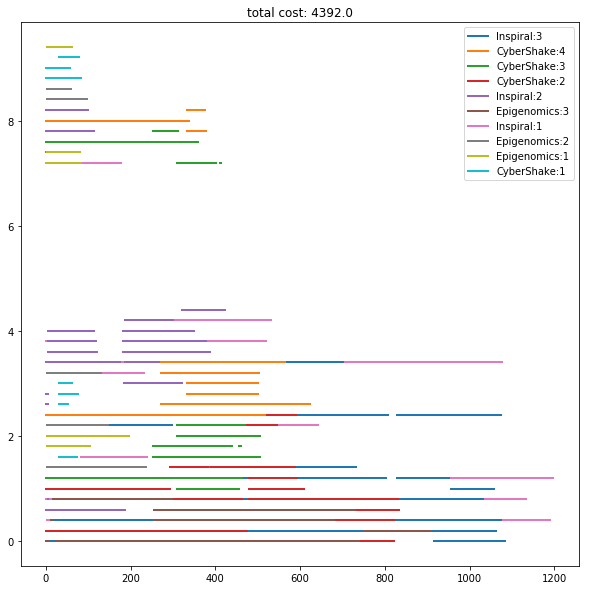

In [13]:
import Scheduler.Multi_Workflow
from db.definitions import Test
import pickle

row, test, job, constraint, names, sizes = read_jobs()
test.time_slot = 1
for r in test.resource_array:
    r[1] *= 12
bandwidth, workload_len, timeslot_list, powers, prices, numbers, power_list, price_list, timeslot_list, resource_spec, main_resources = create_resources()
makespan_list, cost_list, resources_set, graph_set, constraint_values = calculate_reference_plans()
jobs, cloud_resources = create_multi_workflow_resouces()
fair_policy()
show_results()
show_schedule(cloud_resources)

# Read Jobs

In [6]:
%load_ext autoreload
%autoreload 2
import pickle

def read_jobs():
    row, test, job, cnstr, names, sizes = pickle.load(open('dump.pickle', 'rb'))
    constraint = [Constraint.budget if b else Constraint.deadline for b in cnstr]
    return row, test, job, constraint, names, sizes

# create resources

In [5]:
import Definitions

def create_resources():
    bandwidth = test.bandwidth
    workload_len = test.workload_len
    timeslot_list = []
    powers = []
    prices = []
    numbers = []
    for r in test.resource_array:
        powers.append(r[0])
        prices.append(r[1])
        numbers.append(r[2])

    power_list, price_list, timeslot_list = [], [], []
    for i in range(len(test.resource_array)):
        power_list += [powers[i]] * numbers[i]
        price_list += [prices[i]] * numbers[i]
        timeslot_list += [60 * test.time_slot] * numbers[i]

    resource_spec = (power_list, price_list, timeslot_list)

    main_resources = Definitions.Resources.CostAwareResources(resource_spec[0], resource_spec[1], resource_spec[2],bandwidth)
    
    return bandwidth, workload_len, timeslot_list, powers, prices, numbers, power_list, price_list, timeslot_list, resource_spec, main_resources


# Calculate the reference plans

In [4]:
from Definitions.MultiWorkflow.JobList import Constraint
import Scheduler.ICPCP
import Scheduler.HEFT
import Scheduler.BHEFT
import Definitions.Resources
import Scheduler.BudgetPessimistic
import Scheduler.DeadlineOptimisticAlpha
import copy
import Scheduler.Multi_Workflow

def calculate_reference_plans():
    makespan_list = []
    cost_list = []
    resources_set = []
    graph_set = []
    constraint_values = []

    for i in range(workload_len):
        resources = copy.deepcopy(main_resources)
        g = copy.deepcopy(job[i])
        Scheduler.HEFT.schedule(g, resources)
        g_heft = g
        cost = resources.plan_cost
        makespan = resources.makespan

        heft_resources = resources

        if constraint[i] is Constraint.budget:
            c = 'Budget'
            budget_factor = 0.2
            while True:
                resources = copy.deepcopy(main_resources)
                g = copy.deepcopy(job[i])
                Scheduler.BHEFT.schedule(g, resources, cost * budget_factor)
                if cost * budget_factor >= resources.plan_cost:
                    break
                budget_factor += 0.2
            # if budget_factor >= 1:
            #     resources = heft_resources
            #     g = g_heft
            #     constraint_factor = 1
            # else:

            constraint_factor = budget_factor
            constraint_value = cost * budget_factor
        else:
            c = 'Deadline'
            deadline_factor = 1.2

            if sizes[i] == 'XXL':
                if names[i] == 'Montage':
                    deadline_factor = 27
                elif names[i] == 'Sipht':
                    deadline_factor = 13
                elif names[i] == 'Inspiral':
                    deadline_factor = 4

            resources = heft_resources
            first_computation = True
            while True:
                resources = copy.deepcopy(main_resources)
                g = copy.deepcopy(job[i])
                Scheduler.ICPCP.schedule(g, resources, makespan * deadline_factor)
                if makespan * deadline_factor >= resources.makespan:
                    # if resources.plan_cost >= cost:
                    #     resources = heft_resources
                    #     deadline_factor = 1
                    if not first_computation:
                        break
                    else:
                        deadline_factor *= 2
                        first_computation = False
                        continue
                deadline_factor *= 1.2
            constraint_factor = deadline_factor
            constraint_value = makespan * deadline_factor
        print("heft cost:{0:5.1f} | cost:{1:5.1f} | heft ms:{2:5.2f} | ms:{3:5.2f} "
              "| Nodes:{4:4d} | {5:>8} | factor: {6:5.2f}".format(cost, resources.plan_cost, makespan,
                                                                  resources.makespan, len(g.tasks) - 2, c,
                                                                  constraint_factor))

        # ---Store results for next use:
        makespan_list.append(resources.makespan)
        cost_list.append(resources.plan_cost)
        resources_set.append(copy.deepcopy(resources))
        graph_set.append(g)
        constraint_values.append(constraint_value)
    return makespan_list, cost_list, resources_set, graph_set, constraint_values


In [95]:
for m, c, cc in zip(makespan_list, cost_list, constraint_values):
    print(m, c, cc, sep='\t')

160.7404347144708	163.0	163.20000000000002
298.8530383001559	162.0	334.9161109529958
345.0105729965915	268.0	268.0
847.9136712271169	413.0	861.380056222824
321.33350927715503	570.0	570.0
734.8468321057862	429.0	781.5553308982306
1510.752693480146	465.0	471.20000000000005
932.7839674608134	453.0	948.1044638995958
1605.1801913719603	495.0	499.20000000000005
752.5589366680467	480.0	1162.5224978265335


# show
[home](#home)

[show all](#show-all)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random

def show_schedule(resources, save_number=None):
    sched = resources.show_schedule()

    num_plots = sum([len(item[0]) for item in sched])
    figure_number = random.randint(1, 10000)
    fig = plt.figure(figure_number, figsize=[10,10])
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    my_label = []
    for i, entry in enumerate(sched):
        name = entry[0]
        est = entry[1]
        eft = entry[2]
        for j in range(len(est)):
    #         print(i, est[j], eft[j])
            graph_name = name[j].split('-')[0]
            first_visit = False
            if not graph_name in my_label:
                my_label.append(graph_name)
                first_visit = True
#                 print(f'first visit for {graph_name}')
            my_color = my_label.index(graph_name)
            if first_visit:
                plt.plot([est[j], eft[j]], [i/5, i/5], linewidth=2, label=graph_name, 
                         color=colors[my_color])
            else:
                plt.plot([est[j], eft[j]], [i/5, i/5], linewidth=2, 
                         color=colors[my_color])
#             plt.text((est[j] + eft[j]) / 2, i/5 , name[j])
#     print('graph labels: ', my_label)
#     ax = fig.gca()                            # get the current axis
#     for i, p in enumerate(ax.get_lines()):    # this is the loop to change Labels and colors
#         if p.get_label() in names[:i]:    # check for Name already exists
#             idx = names.index(p.get_label())       # find ist index
#             p.set_c(ax.get_lines()[idx].get_c())   # set color
#             p.set_label('_' + p.get_label())       # hide label in auto-legend
    plt.legend(loc='center')

    plt.legend()
    plt.title(f'total cost: {resources.plan_cost}')
    if not save_number is None:
        plt.savefig(f'images/{save_number}', bbox_inches='tight')
        plt.close(figure_number)
    else:
        plt.show()

In [8]:
!rm -r images
!mkdir images
!ls images

# Create the multi-workflow resources

In [2]:
from Definitions.MultiWorkflow.JobList import Constraint, JobItem

def create_multi_workflow_resouces():
    timeslot = test.time_slot
    bandwidth = test.bandwidth
    #    workload_len = test.workload_len
    powers = []
    prices = []
    numbers = []
    for r in test.resource_array:
        powers.append(r[0])
        prices.append(r[1])
        numbers.append(r[2])

    workload_len = test.workload_len

    # ----------------------- End of loading needed things.

    # Preparing the resources in the cloud:

    def type_of_resource(r_id):
        limit = 0
        for p in range(len(numbers)):
            limit += numbers[p]
            if r_id < limit:
                return p
        else:
            return -1

    n = [0] * len(numbers)
    for i in range(workload_len):
        resources = resources_set[i]
        for r in range(0, resources.len):
            if resources.resource_cost(r) != 0:
                n[type_of_resource(r)] += 1

    # TODO: decreasing resources, to force efficient use of resources!
    c_resource = 0.8 # 0.4..1.2
    for i in range(len(n)):
        n[i] = int(n[i] * c_resource)

    power_list, price_list, timeslot_list = [], [], []
    for i in range(len(test.resource_array)):
        power_list += [powers[i]] * n[i]
        price_list += [prices[i]] * n[i]
        # TODO: Tests must be changed, but it works for now (in case of change: both planner and main):
        timeslot_list += [60 * timeslot] * n[i]

    resource_spec = (power_list, price_list, timeslot_list)

    # resource_spec = ([power1] * n[0] + [power2] * n[1] + [power3] * n[2],
    #                  [price1] * n[0] + [price2] * n[1] + [price3] * n[2],
    #                  [timeslot] * (n[0] + n[1] + n[2]))

    cloud_resources = Definitions.Resources.CostAwareResources(resource_spec[0], resource_spec[1], resource_spec[2],
                                                               bandwidth)

    # -------- Making a multi-workflow list, which contains all workflows (they will schedule together)
    jobs = []
    for i in range(workload_len):
        if constraint[i] is Constraint.deadline:
            graph_set[i].makespan = makespan_list[i]  # resources_set[i].makespan
        else:
            graph_set[i].cost = cost_list[i]  # resources_set[i].plan_cost
            graph_set[i].makespan = makespan_list[i]  # resources_set[i].makespan

        prev_resources = resources_set[i]

        job_item = JobItem(copy.deepcopy(job[i]), constraint[i],
                           constraint_values[i], cloud_resources, graph_set[i], prev_resources)
        jobs.append(job_item)

    # prev_cloud_cost = 0
    # previously_scheduled_graph = -1

    current_critical = [0] * workload_len

    # gap-rate calculation:
    gap_rate = [0] * workload_len
    s = gap_rate[:]
    sum_task_number = sum(map(lambda graph: len(graph.tasks), graph_set))
    for i in range(workload_len):
        gap_rate[i] = resources_set[i].gap_rate
        s[i] = len(graph_set[i].tasks) / (gap_rate[i] * sum_task_number)
    iterator = min(s)
    ref_s = s[:]
    return jobs, cloud_resources

# Scheduling

In [12]:
def fair_policy(show_online_schedule=False):
    try:
        # scheduling dummy tasks (get rid of them!):
        for i in range(workload_len):
            jobs[i].scheduler.schedule_next(do_head_nodes=True)
            cloud_resources.costs = cloud_resources.price_of_each_graph()
            # current_critical[i] = jobs[i].critical_now

        figure_number = 1
        ready_list = list(range(workload_len))
        # MAIN WHILE of Scheduler:
        while ready_list:
            cloud_resources.costs = cloud_resources.price_of_each_graph()
            for i in range(len(jobs)):
                job = jobs[i]
                consumed_cost = cloud_resources.costs[job.g.name]
                job.scheduler.remaining_budget = job.scheduler.total_budget - consumed_cost
                job.scheduler.recalculate_sub_budget()

            most_critical = -1
            criticality = 100
            ready_list_index = -1
            for index, ii in enumerate(ready_list):
                job = jobs[ii]
                current_critical = job.critical_now
                if current_critical < criticality:
                    criticality = current_critical
                    most_critical = ii
                    ready_list_index = index

            if show_online_schedule:
                show_schedule(cloud_resources, figure_number)
            figure_number += 1
            job_index = most_critical  # ready_list[most_critical]
            job = jobs[job_index]
#             print([round(j.critical_now, 2) for j in jobs if j.critical_now < 1000000000.0],
#                   f' - most critical: {jobs[most_critical].critical_now:.2f}, selected: {job.critical_now:.2f}')
            del ready_list[ready_list_index]

            job.scheduler.schedule_next(do_head_nodes=True)

            if job.scheduler.finished:
                continue
            else:
                ready_list.append(job_index)
        return
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        raise e

# Barbosa

heft cost:252.0 | cost:192.0 | heft ms:75.40 | ms:82.57 | Nodes:  30 |   Budget | factor:  0.80
heft cost:300.0 | cost:240.0 | heft ms:151.57 | ms:214.52 | Nodes:  24 |   Budget | factor:  0.80
heft cost:312.0 | cost:240.0 | heft ms:167.38 | ms:236.90 | Nodes:  24 |   Budget | factor:  0.80
heft cost:612.0 | cost:360.0 | heft ms:251.54 | ms:1543.81 | Nodes:  30 |   Budget | factor:  0.60
heft cost:672.0 | cost:444.0 | heft ms:423.23 | ms:657.54 | Nodes:  24 | Deadline | factor:  2.40
heft cost:708.0 | cost:552.0 | heft ms:314.41 | ms:440.25 | Nodes:  30 |   Budget | factor:  0.80
heft cost:744.0 | cost:504.0 | heft ms:350.05 | ms:791.12 | Nodes:  30 | Deadline | factor:  2.40
heft cost:816.0 | cost:648.0 | heft ms:370.76 | ms:553.02 | Nodes:  30 |   Budget | factor:  0.80
heft cost:816.0 | cost:648.0 | heft ms:396.33 | ms:623.16 | Nodes:  30 |   Budget | factor:  0.80
heft cost:864.0 | cost:576.0 | heft ms:381.98 | ms:1045.46 | Nodes:  30 | Deadline | factor:  2.88

+---+----------+---

C:\Users\amin\Anaconda3\envs\micasense\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


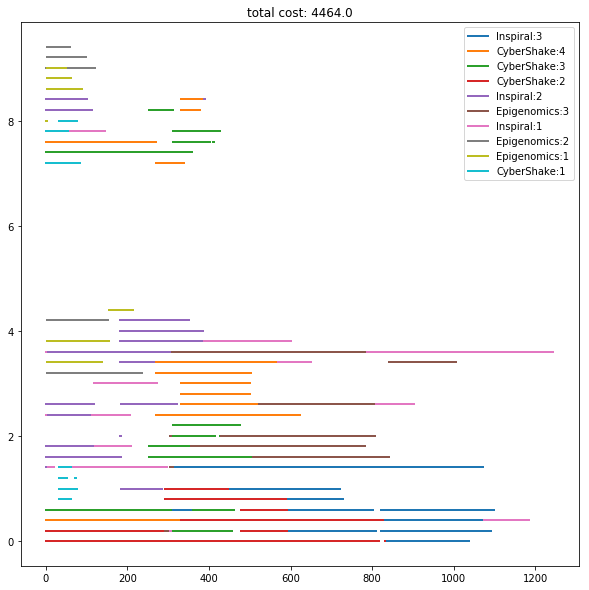

In [14]:
import Scheduler.Multi_Workflow
from db.definitions import Test
import pickle

row, test, job, constraint, names, sizes = read_jobs()
test.time_slot = 1
for r in test.resource_array:
    r[1] *= 12
bandwidth, workload_len, timeslot_list, \
powers, prices, numbers, power_list, price_list, \
timeslot_list, resource_spec, main_resources = create_resources()

makespan_list, cost_list, resources_set, graph_set, constraint_values = calculate_reference_plans()
jobs, cloud_resources = create_multi_workflow_resouces()
barbosa()
show_results()
show_schedule(cloud_resources)

In [7]:
from IPython.core.debugger import set_trace

def barbosa(): # unfinished!
    try:
        k = 1
        # scheduling dummy tasks (get rid of them!):
        for i in range(workload_len):
            jobs[i].scheduler.schedule_next(do_head_nodes=True)
            cloud_resources.costs = cloud_resources.price_of_each_graph()
            # current_critical[i] = jobs[i].critical_now

        ready_list = list(range(workload_len))
        # MAIN WHILE of Scheduler:
        while ready_list:
            cloud_resources.costs = cloud_resources.price_of_each_graph()
            for i in range(len(jobs)):
                job = jobs[i]
                consumed_cost = cloud_resources.costs[job.g.name]
                job.scheduler.remaining_budget = job.scheduler.total_budget - consumed_cost
                job.scheduler.recalculate_sub_budget()

            k += 1
            
            most_critical = -1
            criticality = 100
            ready_list_index = -1
            for index, ii in enumerate(ready_list):
                job = jobs[ii]

                SDi = job.scheduler.g.tasks[job.scheduler.last_unscheduled_task_id].sub_deadline
                if hasattr(job.reference_graph, 'deadline'):
                    Dj = job.reference_graph.deadline
                else:
                    Dj = job.reference_graph.makespan
                TimeR = (Dj - SDi) / Dj

                number_of_tasks = len(job.scheduler.priority_list)
                PRTj = (number_of_tasks - job.scheduler.last_unscheduled_task_id) / number_of_tasks
                
#                 if k >= 200:
#                     set_trace()

                current_critical = TimeR * PRTj
                if most_critical == -1 or current_critical < criticality:
                    criticality = current_critical
                    most_critical = ii
                    ready_list_index = index

            job_index = most_critical  # ready_list[most_critical]
            job = jobs[job_index]
            del ready_list[ready_list_index]

            job.scheduler.schedule_next(do_head_nodes=True)

            if job.scheduler.finished:
                continue
            else:
                ready_list.append(job_index)
        return
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        raise e

# Call scheduling

In [100]:
fair_policy()

# Create scheduling movie!

In [31]:
import os
import imageio
folder = '1 img/images-old-cost-method'
filenames = [f'{folder}/{filename}.png' for filename in range(1, 1 + len(os.listdir(folder)))]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie2.gif', images)

# Show results

In [101]:
list(zip(cloud_resources.power, cloud_resources.price))
cloud_resources.costs

{'Montage:1': 169.79523726283736,
 'Inspiral:1': 167.1420195968036,
 'CyberShake:1': 286.7265742074594,
 'Montage:2': 418.39859611639474,
 'CyberShake:2': 578.027554087064,
 'CyberShake:3': 441.8834135662651,
 'Epigenomics:1': 489.88470380306796,
 'Montage:3': 463.7415628648638,
 'Epigenomics:2': 549.7913710456814,
 'Epigenomics:3': 484.6089674495605}

In [9]:
def show_results():
    # ------------ printing the result of scheduling:
    print()
    costs = cloud_resources.price_of_each_graph()
    sum_separate = 0
    s_e = []
    print('+---+----------+--------+--------+--------+---------+--------+--------+------+------+')
    print('|job|constraint| value  | ms old | ms new |prev cost|new cost|gap-rate|c-rate|m-rate|')
    print('+---+----------+--------+--------+--------+---------+--------+--------+------+------+')
    for i in range(len(jobs)):
        prev_makespan = makespan_list[i]  # resources_set[i].makespan
        if graph_set[i].endID not in cloud_resources.job_task_schedule[graph_set[i].name]:
            print("|{:3d}|problem!".format(i))
            continue
        cloud_makespan = cloud_resources.job_task_schedule[graph_set[i].name][graph_set[i].endID].EFT
        prev_cost = cost_list[i]  # resources_set[i].plan_cost
        cloud_cost = costs[graph_set[i].name]
        m_rate = prev_makespan / cloud_makespan
        c_rate = prev_cost / cloud_cost
        if constraint[i] is Constraint.deadline:
            c = ' Deadline '
            m_rate = constraint_values[i] / cloud_makespan
            s_e.append(c_rate)
        else:
            c = '  Budget  '
            c_rate = constraint_values[i] / cloud_cost
            s_e.append(m_rate)
        print('|{:3d}|{}|{:8.3f}|{:8.3f}|{:8.3f}'
              '|{:9.0f}|{:8.2f}|{:8.5f}|{:6.4f}|{:6.4f}|'
              ''.format(i, c, constraint_values[i], prev_makespan, cloud_makespan,
                        prev_cost, cloud_cost, resources_set[i].gap_rate,
                        c_rate, m_rate))
        deadline = -1
        budget = -1
        if constraint[i] is Constraint.deadline:
            deadline = constraint_values[i]
        else:
            budget = constraint_values[i]

        job_name = names[i]
        job_size = len(graph_set[i].tasks) - 2

        sum_separate += cost_list[i]  # resources_set[i].plan_cost
    print('+---+----------+--------+--------+--------+---------+--------+--------+------+------+')

    A = sum(s_e) / workload_len
    sigma_u = 0
    for se in s_e:
        sigma_u += abs(se - A)
    U = sigma_u / workload_len
    print()
    print("Overall Cloud Cost:{:6.3f}".format(cloud_resources.plan_cost))
    print("Separate Runs Cost:{:6.3f}".format(sum_separate))
    print("\nUnfairness:{:8.5f}".format(U))

    cloud_resources_gap_rate = cloud_resources.gap_rate
    print("\nCloud gap-ratio:{:8.5f}".format(cloud_resources_gap_rate))

In [90]:
cloud_resources.plan_cost/sum([costs[k] for k in costs])

0.982473463342385

# show all
[home](#home)

[show](#show)

[barbosa method](#Barbosa)